# Imports

In [1]:
import os 
os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query
from src.data.data_statics import (
    MIN_TOKENS_SUMMARY,
    MIN_TOKENS_BODY,
    MIN_COMPRESION_RATIO,
    MAX_COMPRESION_RATIO,
    MAX_TOKENS_SUMMARY,
    SQL_WIKI_DUMP,
)

#  Constants

In [4]:
plt.rcParams["figure.figsize"] = (12.5,7.5)

# Read data

We will only consider articles which data quality is relevant to our task. 
There are over 21M articles but a lot of them are redirects or poor quality summaries, in this section, the first filtering method that we will consider will be the length of both the summary and the body as well as the compression ratio.
The levels used for this are outlined bellow.

Which means that we go from about 21M articles to ~1.4M

In [5]:
print("MIN_TOKENS_SUMMARY: ", MIN_TOKENS_SUMMARY)
print("MIN_TOKENS_BODY: ", MIN_TOKENS_BODY)
print("MAX_TOKENS_SUMMARY: ", MAX_TOKENS_SUMMARY)
print("MIN_COMPRESION_RATIO: ", MIN_COMPRESION_RATIO)
print("MAX_COMPRESION_RATIO: ", MAX_COMPRESION_RATIO)



MIN_TOKENS_SUMMARY:  40
MIN_TOKENS_BODY:  250
MAX_TOKENS_SUMMARY:  512
MIN_COMPRESION_RATIO:  0.05
MAX_COMPRESION_RATIO:  0.3


In [6]:
query = f"""
SELECT *
FROM article_level_info
WHERE body_word_count>={MIN_TOKENS_BODY} 
    AND summary_word_count>={MIN_TOKENS_SUMMARY}
    AND summary_word_count<={MAX_TOKENS_SUMMARY}
    AND CAST( summary_word_count AS FLOAT)/ CAST( body_word_count AS FLOAT) >= {MIN_COMPRESION_RATIO}
    AND CAST( summary_word_count AS FLOAT)/CAST( body_word_count AS FLOAT) <= {MAX_COMPRESION_RATIO}
"""

data = retrieve_query(query, out_f=SQL_WIKI_DUMP)

In [7]:
data = pd.DataFrame(
    data,
    columns=["pageid", "title", "summary_word_count", "body_word_count"],
)

In [8]:
print(f"Number of observations: {len(data)}")

Number of observations: 290852


# Evaluate distribution

In [9]:
data.head()

,pageid,title,summary_word_count,body_word_count
0,12,Anarchism,357,6950
1,25,Autism,398,7395
2,39,Albedo,384,2963
3,290,A,141,1914
4,309,An American in Paris,162,1765


In [10]:
data.describe()

,pageid,summary_word_count,body_word_count
count,2.908520e+05,290852.000000,290852.000000
mean,1.232609e+06,139.776422,1338.104510
std,9.296269e+05,94.905994,1160.856606
min,1.200000e+01,40.000000,250.000000
25%,3.840862e+05,70.000000,594.000000
50%,1.073914e+06,109.000000,954.000000
75%,1.986480e+06,179.000000,1638.000000
max,3.166080e+06,512.000000,10091.000000


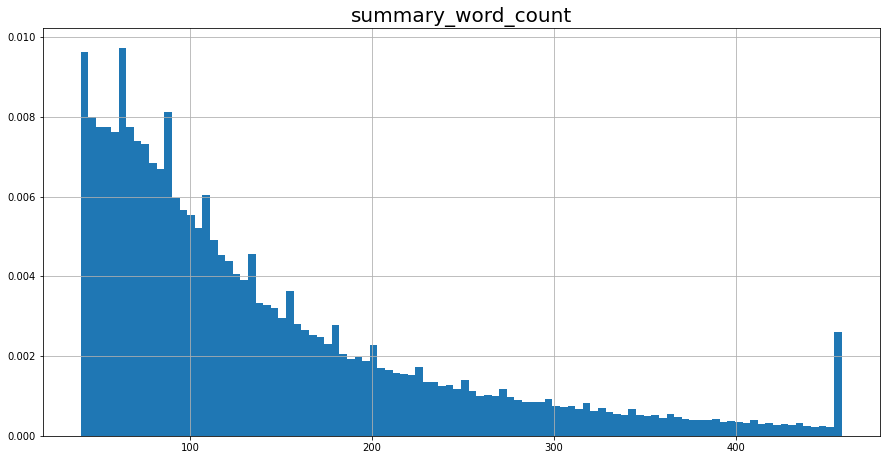

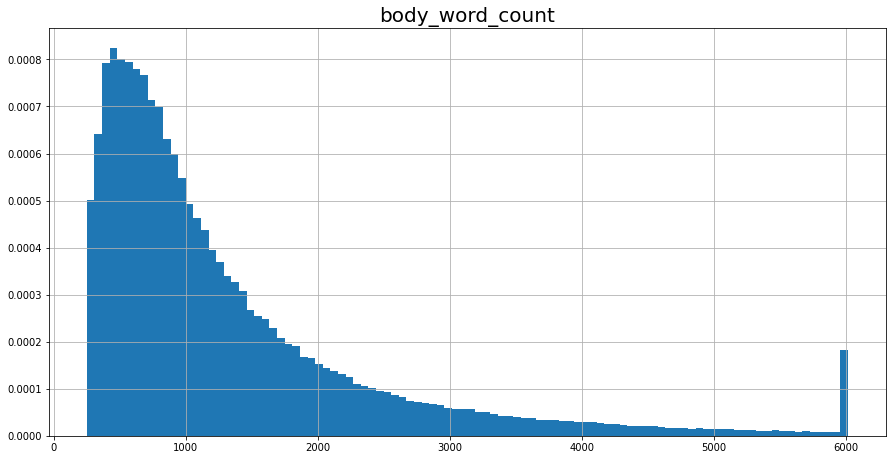

In [11]:
for var in [ "summary_word_count", "body_word_count"]:
    plt.figure(figsize = (15,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.99)
    data[var].clip(0,quantile).hist(bins = int(min(100,quantile)), density = True)
    plt.show()
    

# Ratios

In [12]:
data["tokens_ratio_summary_body"]=data["summary_word_count"]/data["body_word_count"]

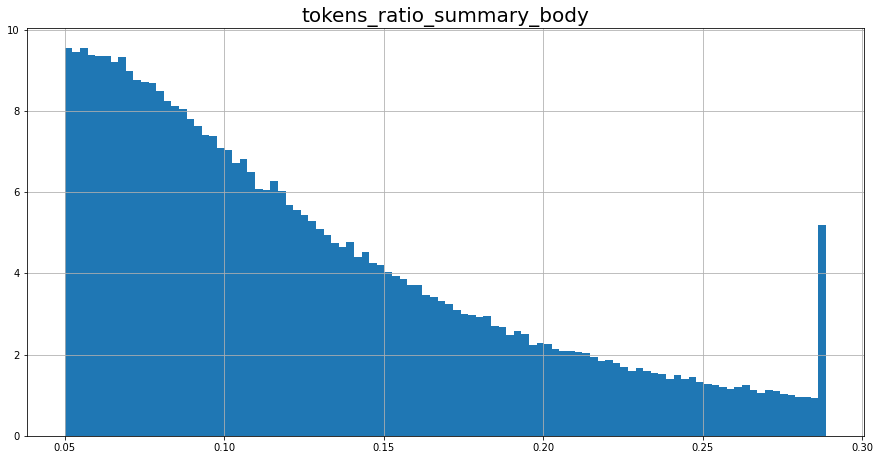

0.11042944785276074


In [13]:
for var in ["tokens_ratio_summary_body"]:
    plt.figure(figsize = (15,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.99)
    data[var].clip(0,quantile).hist(bins = 100, density = True)
    plt.show()
    print(data[var].median())

# Joint plots

In [14]:
cols_to_clip = ["tokens_ratio_summary_body","summary_word_count","body_word_count"]
for var in cols_to_clip :
    quantile = data[var].quantile(0.90)
    data[var + "_clip"] = data[var].clip(0, quantile)
    

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]

    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)
    
    plt.show()

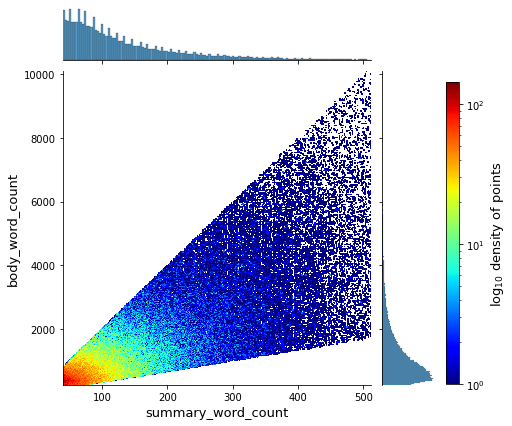

In [16]:
plot_joint(
    data,
    "summary_word_count",
    "body_word_count",
    bins=(500, 500),
)

In [23]:
query =f"""
SELECT wk.*,ar.title
FROM article_level_info ar
LEFT JOIN wiki_articles wk 
    ON ar.pageid = wk.pageid
WHERE ar.body_word_count>15 and ar.summary_word_count>150 --AND ar.pageid>20000
LIMIT 20
"""

data_text = retrieve_query(query)

In [24]:
import pickle 

In [27]:
for i in data_text:
    print("-" * 100)
    pageid = i[0]
    section_title = i[1]
    summary = i[2]
    body_sections = i[3]
    section_word_count = i[4]
    title = i[5]
    
    print("pageid: ", pageid)
    print("section_title: ", pickle.loads(section_title))
    print("title: ",title)
    print("summary: ", summary)
    print("body: ","".join(pickle.loads(body_sections)))
    print("section_word_count: ", pickle.loads(section_word_count))
    

----------------------------------------------------------------------------------------------------
pageid:  12
section_title:  ['Etymology, terminology, and definition', 'History', 'Thought', 'Tactics', 'Key issues', 'Analysis']
title:  Anarchism
summary:   

Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be undesirable, unnecessary, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.

The history of anarchism goes back to prehistory, when humans lived in anarchic societies long before the establishment of formal states, realms, or empires. With the rise of organised hierarch